<a href="https://colab.research.google.com/github/adalbertii/Modele-regresyjne/blob/main/mpg-case-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Analiza modeli neuronowych**

Wykorzystanie danych  [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg).

[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


Demonstracja sposobu budowania modelu przeznaczonego do predykcji efektywnosci spalania paliwa.

Tok działania:
- pobranie danych i ich wstępna analiza
- uproszczona standaryzacja danych

- budowa modelu opratego na jednym neuronie i jednym atrybucie (zmiennej objaśnijającej)

- budowa modelu składającego się z jednego neurona i wykorzystującego wszystkie zmienne objaśniajace

*   budowa modelu składajacego się z 64 neuronów i jednej zmiennej objaśniajacej

*    budowa modelu 64 neronowego ze wsystkimi zmiennymi objaśniajacymi

In [1]:
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.13.0


### Pobranie danych do uczenia modeli
Wykorzystanie modułu pandas


In [70]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Liczba cylindrow', 'Pojemność skokowa', 'Moc', 'Waga',
                'Przyspieszenie', 'Rok modelu', 'Pochodzenie']
# mpg - miles per gallon
raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [71]:
# tworzymy kopie zbioru danych
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Liczba cylindrow,Pojemność skokowa,Moc,Waga,Przyspieszenie,Rok modelu,Pochodzenie
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [72]:
dataset.head(20)

,MPG,Liczba cylindrow,Pojemność skokowa,Moc,Waga,Przyspieszenie,Rok modelu,Pochodzenie
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
5,15.0,8,429.0,198.0,4341.0,10.0,70,1
6,14.0,8,454.0,220.0,4354.0,9.0,70,1
7,14.0,8,440.0,215.0,4312.0,8.5,70,1
8,14.0,8,455.0,225.0,4425.0,10.0,70,1
9,15.0,8,390.0,190.0,3850.0,8.5,70,1


In [73]:
## sprawdzamy charakterystykę atrybutów pobranego zbioru danych
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MPG                398 non-null    float64
 1   Liczba cylindrow   398 non-null    int64  
 2   Pojemność skokowa  398 non-null    float64
 3   Moc                392 non-null    float64
 4   Waga               398 non-null    float64
 5   Przyspieszenie     398 non-null    float64
 6   Rok modelu         398 non-null    int64  
 7   Pochodzenie        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


Atrybut 'pochodzenie' wymaga uwagi. To jest ukryta zmienna kategoryczna

In [74]:
# sprawdzamy rozkład statystyczne zmiennych
dataset.describe()

,MPG,Liczba cylindrow,Pojemność skokowa,Moc,Waga,Przyspieszenie,Rok modelu,Pochodzenie
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [75]:
# sprawdzamy korelacje zmiennych
dataset.corr()['MPG'].sort_values(ascending=False)


MPG                  1.000000
Rok modelu           0.579267
Pochodzenie          0.563450
Przyspieszenie       0.420289
Liczba cylindrow    -0.775396
Moc                 -0.778427
Pojemność skokowa   -0.804203
Waga                -0.831741
Name: MPG, dtype: float64

In [76]:
import plotly.express as px

In [77]:
#sprawdzamy rozkłady wartości MPG dla różnych krajów pochodzenia
#px.histogram(dataset, width=1400, height=800, nbins=50)
px.histogram(dataset, x='MPG', width=1000, height=400, nbins=50, facet_col='Pochodzenie')

In [ ]:
#sprawdzamy rozkłady wartości MPG w  zależności od liczny cylindów
px.histogram(dataset, x='MPG', width=1000, height=400, nbins=50, facet_col='Liczba cylindrow')

In [ ]:
#sprawdzamy rozkłady wartości MPG w  zależności od roku modelu samochodu
px.histogram(dataset, x='Rok modelu', width=1000, height=400, nbins=50)

### Wstępne przygotowanie danych




In [78]:
# sprawdzamy czy występują braki danych
dataset.isna().sum()

MPG                  0
Liczba cylindrow     0
Pojemność skokowa    0
Moc                  6
Waga                 0
Przyspieszenie       0
Rok modelu           0
Pochodzenie          0
dtype: int64

Istnieją braki danych.
Dla uproszczenia usuwamy rekordy zawierajace braki danych

In [79]:
# Istnieją braki danych. Dla uproszczenia usuwamy rekordy zawierajace braki danych

dataset = dataset.dropna()

In [80]:
dataset.isna().sum()

MPG                  0
Liczba cylindrow     0
Pojemność skokowa    0
Moc                  0
Waga                 0
Przyspieszenie       0
Rok modelu           0
Pochodzenie          0
dtype: int64

In [81]:
# sprawdzenie czy występują duplikaty

dataset[dataset.duplicated()]

,MPG,Liczba cylindrow,Pojemność skokowa,Moc,Waga,Przyspieszenie,Rok modelu,Pochodzenie


Kolumna 'Pochodzenie` jet atrybutem kategorycznym, nie numerycznym .
Nalezy zatem przeprowadić na tej kolumnie transfomację "one-hot-encod".
W tym celu wykorzystana zostanie  metoda [pd.get_dummies]

In [82]:

# najpierw dokonujemy konwersji liczb (int64)  na oznaczenie tekstowe
dataset['Pochodzenie'] = dataset['Pochodzenie'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [83]:
dataset.head(5)

,MPG,Liczba cylindrow,Pojemność skokowa,Moc,Waga,Przyspieszenie,Rok modelu,Pochodzenie
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA


In [84]:
dataset.Pochodzenie.unique()

array(['USA', 'Japan', 'Europe'], dtype=object)

In [85]:
# bardzo ważna operacja kodowania zmiennej kategorycznej 'Pochodzenie'
dataset = pd.get_dummies(dataset,  columns=['Pochodzenie'], prefix='',prefix_sep='') ###
dataset.tail()

,MPG,Liczba cylindrow,Pojemność skokowa,Moc,Waga,Przyspieszenie,Rok modelu,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Podział danych na dane treningowe i testowe

Dane testowe zostaną wykorzystane do końcowej ewaluacji modelu

In [86]:
dataset.shape

(392, 10)

In [87]:
# operacja zwraca 80% danych wybranych losowo)
train_dataset = dataset.sample(frac=0.8, random_state=0)

# usuwamy rekordy o indexach przydzilonych do rekordów z poprzedniej operacji
test_dataset = dataset.drop(train_dataset.index)

In [88]:
train_dataset.shape

(314, 10)

In [89]:
test_dataset.shape

(78, 10)

### Wstępna analiza danych



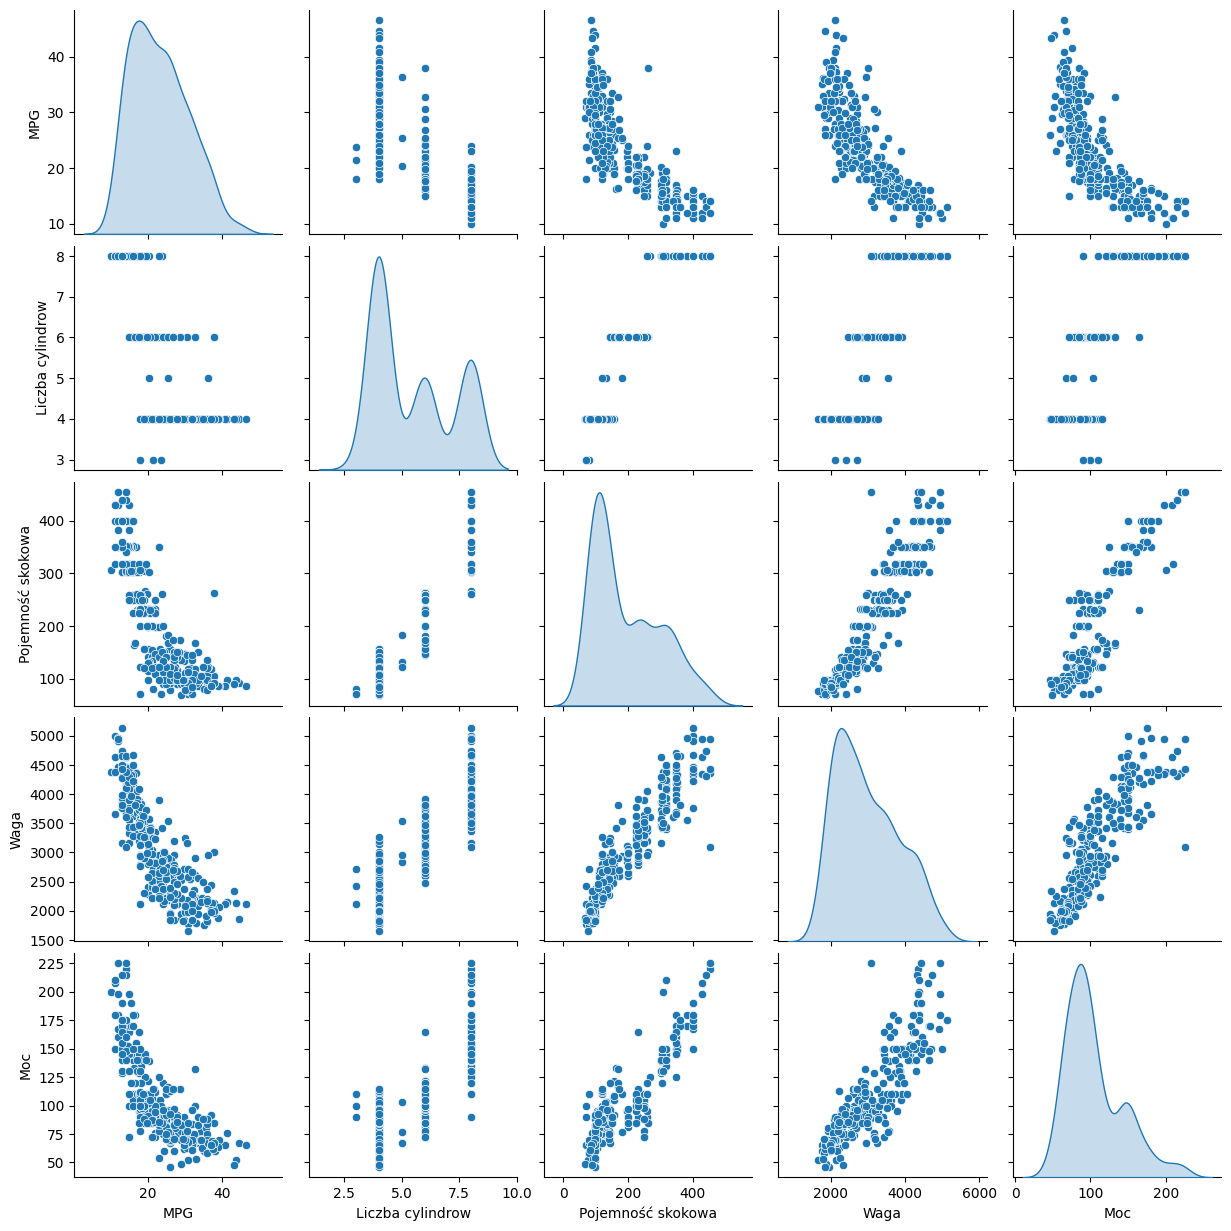

In [ ]:
sns.pairplot(train_dataset[['MPG', 'Liczba cylindrow', 'Pojemność skokowa', 'Waga','Moc']], diag_kind='kde')

Weryfikacja rozkładów statystycznych zmiennych objaśniajacych

In [90]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Liczba cylindrow,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Pojemność skokowa,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Moc,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Waga,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Przyspieszenie,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Rok modelu,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Rozdzielenie zmiennych objaśniajacych od zmiennej objaśnianej (etykiety)


In [91]:
# najpierw same cechy (zmienne objaśniajaće)
train_features = train_dataset.copy()
test_features = test_dataset.copy()



In [92]:
train_features.head(5)

,MPG,Liczba cylindrow,Pojemność skokowa,Moc,Waga,Przyspieszenie,Rok modelu,Europe,Japan,USA
146,28.0,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,22.3,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,12.0,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,38.0,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,33.8,4,97.0,67.0,2145.0,18.0,80,0,1,0


In [93]:
# teraz tzw. etykiety, czyli zmenne objaśniane
# operacja poniższa zwraca warosci kolumny 'MPG' , jedocześnie usuwając tąkolumnę z ramki danych
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [94]:
train_features.shape

(314, 9)

In [95]:
train_features

,Liczba cylindrow,Pojemność skokowa,Moc,Waga,Przyspieszenie,Rok modelu,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [96]:
train_labels

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

## Normalizacja danych



In [97]:
# najpierw sprawdzam jak bardzo zróznicowane wartościowo są poszczególne atrybury
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Liczba cylindrow,5.477707,1.699788
Pojemność skokowa,195.318471,104.331589
Moc,104.869427,38.096214
Waga,2990.251592,843.898596
Przyspieszenie,15.559236,2.789230
Rok modelu,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101



Wartość średnia i odchylenie standardowe jest mocno żróżnicowane.

Dobrą praktyką jest normalizacja cech, które używają różnych skal i zakresów.

Jednym z powodów, dla których jest to ważne, jest to, że cechy są mnożone przez wagi modelu. Tak więc skala wyników i skala gradientów zależy od skali danych wejściowych.

Chociaż model *może* uczyć  się bez normalizacji cech, normalizacja sprawia, że szkolenie jest znacznie bardziej stabilne.


### Warstwa normalizująca  dane

Tworzymy instancję normalizatora

In [98]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Dokonujemy normalizacji zmiennych objaśniajacych :

In [99]:
# metoda "adapt" wymaga obiektu np.array
normalizer.adapt(np.array(train_features))

Gdy warstwa jest wywoływana, zwraca dane wejściowe, z każdą cechą niezależnie znormalizowaną:

In [100]:
# demonstracja działania normalizotora
# pobieramy 1 wiersz
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('Wiersz przed normalizacja:', first)
  print()
  print('Wiersz znormalizowany    :', normalizer(first).numpy())

Wiersz przed normalizacja: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Wiersz znormalizowany    : [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Regresja liniowa

Przed zbudowaniem głebokiej sieci neuronowej przeanalizujemu budowę liniowej sieci z jedną i wieloma cechami (zmiennymi objaśniajacymi)

### Regresja lionowa z jedną zmienną objaśniajacą

Predykcja 'MPG' na podstwie zmiennej 'Moc'.

Sieć neuronowa będzie zbudowana z dwóch warstw:

- warstwy normalizującej atrybut wejściowy 'moc` (przy użyciu klasy  `tf.keras.layers.Normalization).
- warstwy Dense

In [101]:
horsepower = np.array(train_features['Moc'])
horsepower


array([ 75.,  88., 160.,  63.,  67.,  90.,  60.,  67.,  95.,  88.,  60.,
       180.,  88., 150., 155.,  75., 115., 150.,  90.,  90., 129., 110.,
        90., 110.,  76., 165.,  92.,  88., 100., 150., 122.,  74.,  76.,
        67., 110.,  90.,  65., 150., 150., 220., 165.,  67.,  75., 140.,
        78., 149.,  84., 150., 145., 100.,  75., 170., 200.,  72.,  78.,
        76.,  88., 105.,  53.,  86.,  95.,  75.,  71., 198.,  69., 105.,
       215.,  88.,  87.,  65.,  60.,  68., 129., 145.,  95., 153.,  70.,
       145.,  68.,  70., 100.,  70.,  81.,  95., 225.,  90.,  97., 100.,
        65., 110.,  89., 150., 110.,  95.,  85.,  97.,  60.,  88.,  52.,
        70., 198.,  71.,  90.,  72.,  63., 115.,  90., 135.,  52., 150.,
       170.,  58.,  96., 125.,  92.,  95.,  90.,  95.,  82., 110.,  78.,
        67., 208., 105., 130., 150.,  46.,  90.,  64.,  75.,  85.,  72.,
        95.,  90., 145.,  88., 167., 120., 190.,  78.,  49.,  86., 150.,
        70., 107.,  80., 150., 105., 100., 145.,  8

In [102]:
horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

Budowa modelu Keras

In [103]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


Po zbudowaniu modelu należy go skompilować.

Na tym etapie kluczowy jest dobór hiperparametrów modelu:
*   'loss'
*   'optimizer'



In [104]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Proces uczenia modelu

In [105]:
%%time

# zmienna history będzie zawierała pełną charakterystyką zrealizowanego procesu uczenia
history = horsepower_model.fit(
    train_features['Moc'],
    train_labels,
    epochs=100,
    verbose=1,
    validation_split = 0.2) #Oblicza wyniki walidacji na 20% danych treningowych

Epoch 1/100
8/8 [==============================] - 1s 25ms/step - loss: 22.8707 - val_loss: 22.9364
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 22.0661 - val_loss: 22.1360
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 21.2620 - val_loss: 21.3361
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 20.4616 - val_loss: 20.5361
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 19.6623 - val_loss: 19.7362
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 18.8664 - val_loss: 18.9363
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 18.0614 - val_loss: 18.1362
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 17.2625 - val_loss: 17.3363
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 16.4639 - val_loss: 16.5361
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 15.6641 - val_loss: 15.7362
Epoch 

Wizualizacja procesu uczenia przy użyciu statystyk zapisanych w obiekcie `history`.

In [106]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.803419,4.206629,95
96,3.803436,4.189158,96
97,3.806279,4.201028,97
98,3.805681,4.180495,98
99,3.806095,4.186438,99


In [107]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

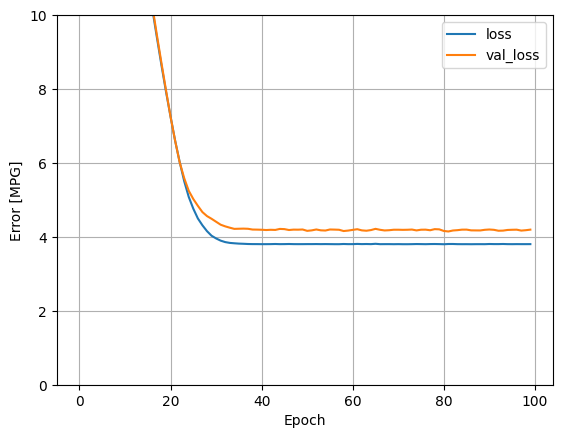

In [42]:
plot_loss(history)

In [108]:
horsepower_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [109]:
# wyświetlimy wyznaczone współczynniki wagowe modelu

wagi = horsepower_model.get_weights()
wagi

[104.869446,
 1446.6993,
 314,
 array([[-6.315]], dtype=float32),
 array([22.536], dtype=float32)]

Zachowanie rezultatów na poźniejsze porównania

In [110]:
# tworzymy słownik dla oceny wskażników ewaluacyjnych (stopnia dokładności predykcyjnej modelu)
test_results = {}

# obliczamy współczynnik loss dla danych testowych w opariu o metodę "evaluate"
test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Moc'], # dane dla jednej zmiennej objaśnijacej
    test_labels, # dla danych TESTOWYCH
    verbose=1) # etykiety dla danych tesowych

3/3 [==============================] - 0s 5ms/step - loss: 3.6610


In [111]:
#wynik (loss) dla danych tesowych , dla modelu z jednym neuronem
test_results

{'horsepower_model': 3.661005973815918}

Ponieważ jest to regresja pojedynczej zmiennej, łatwo jest wyświetlić prognozy modelu jako funkcję danych wejściowych.

In [112]:
# generujemy dane" testowe" do weryfikacji wyników predykcji
x = tf.linspace(50.0, 150, 251)


In [113]:
# dokonujemy predykcji MPG na podstwie danych testowych
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


In [48]:
y

array([[40.136],
       [39.968],
       [39.801],
       [39.633],
       [39.465],
       [39.298],
       [39.13 ],
       [38.962],
       [38.795],
       [38.627],
       [38.459],
       [38.292],
       [38.124],
       [37.956],
       [37.789],
       [37.621],
       [37.453],
       [37.286],
       [37.118],
       [36.95 ],
       [36.783],
       [36.615],
       [36.447],
       [36.28 ],
       [36.112],
       [35.944],
       [35.777],
       [35.609],
       [35.441],
       [35.274],
       [35.106],
       [34.938],
       [34.771],
       [34.603],
       [34.435],
       [34.268],
       [34.1  ],
       [33.932],
       [33.765],
       [33.597],
       [33.429],
       [33.262],
       [33.094],
       [32.926],
       [32.759],
       [32.591],
       [32.424],
       [32.256],
       [32.088],
       [31.921],
       [31.753],
       [31.585],
       [31.418],
       [31.25 ],
       [31.082],
       [30.915],
       [30.747],
       [30.579],
       [30.412

In [114]:
# definiuję procedurę do tworzenia wykresu
# wykres złożony  z danymi treningowymi  oraz wynikami predykcji dla danych "testowych"
def plot_horsepower(x, y):

  plt.scatter(train_features['Moc'], train_labels, label='Data')

  plt.plot(x, y, color='r', label='Predictions')

  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

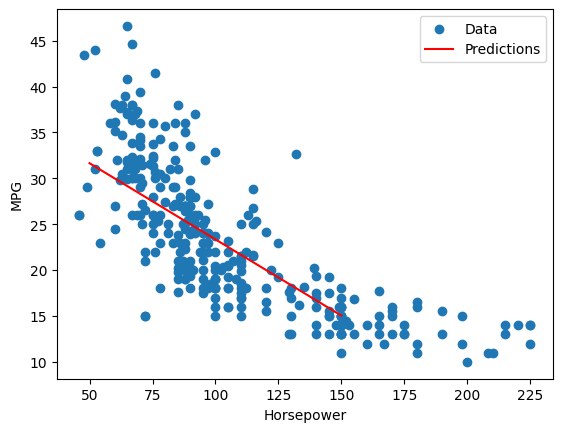

In [115]:
plot_horsepower(x, y)

### Regresja liniowa z wieloma zmiennymi objaśniajacymi

Ponownie budujemy dwuetapowy model sekwencyjny Keras z pierwszą warstwą będącą normalizatorem (tf.keras.layers.Normalization(axis=-1)), który zdefiniowaliśmy wcześniej i dostosowali  do całego zbioru danych (wszystkie zmienne objaśniajace)


In [116]:
# definujemy taki sam jak poprzednio model (z taką samą topologię)
linear_model = tf.keras.Sequential([
    normalizer, # obiekt normalize zawieratym razem  znormalizowane wartości wszystkich atrybutów(zmiennych objasniających)
    layers.Dense(units=1)
])

Kompilujemy model i przechodzimy do jego uczenia

In [117]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [118]:
# ustawiam takie same wartości hiperparametrów jak poprzednio
%%time
history = linear_model.fit(
    train_features,# wszzystkie zmienne objasniajace
    train_labels,
    epochs=100,
    verbose=1,
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 1s 29ms/step - loss: 22.9055 - val_loss: 23.1877
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 22.0253 - val_loss: 22.4552
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 21.1872 - val_loss: 21.7015
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 20.3712 - val_loss: 20.9597
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 19.5667 - val_loss: 20.2548
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 18.7542 - val_loss: 19.5498
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 17.9119 - val_loss: 18.8059
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 17.1016 - val_loss: 18.0763
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 16.2877 - val_loss: 17.3726
Epoch 10/100
8/8 [==============================] - 0s 8ms/step - loss: 15.4651 - val_loss: 16.6681
Epoch 1

Wykorzystując wszystkie zmienne objaśniajace uzyskujemy znacznie niższy błąd treningowy i walidacyjny niż w poprzedniom modelu (`horsepower_model`)

In [119]:
linear_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normaliza  (None, 9)                 19        
 tion)                                                           
                                                                 
 dense_4 (Dense)             (None, 1)                 10        
                                                                 
Total params: 29 (120.00 Byte)
Trainable params: 10 (40.00 Byte)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


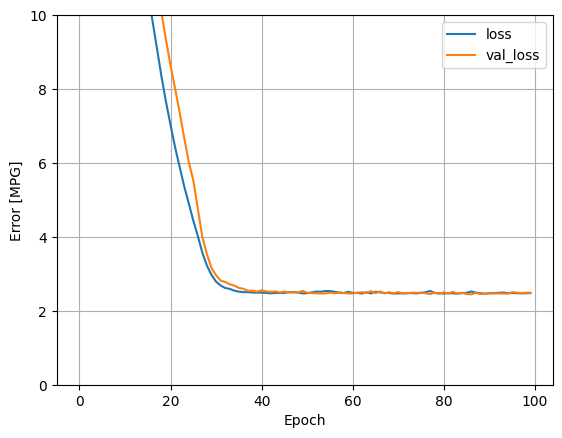

In [120]:
plot_loss(history)

Zapisujemy wyniki ewaluacji modelu dla danych testowych

In [121]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=1)

3/3 [==============================] - 0s 4ms/step - loss: 2.5101


I porównajmy wskażniki ewaluacyjne dla dwóch modeli  z jedną zmienna objaśniającą i wieloma zmiennymi objasniającymi

In [122]:
print(test_results)

{'horsepower_model': 3.661005973815918, 'linear_model': 2.51005220413208}


## Regresja za pomocą sici głębokich [deep neural network (DNN)]


Zaimplementujemy  modele DNN z pojedynczym i wieloma wejściami.

Kod jest zasadniczo taki sam, z wyjątkiem tego, że model jest rozszerzony o niektóre "ukryte" warstwy nieliniowe.

Modele te będą zawierać kilka warstw więcej niż model liniowy:

Liniowa warstwa Dense z pojedynczym wyjściem.


*   Warstwa normalizacji, jak poprzednio (z horsepower_normalizer dla modelu z jednym wejściem i normalizer dla modelu z wieloma wejściami).

*   Dwie ukryte, nieliniowe warstwy Dense z nieliniowością funkcji aktywacji ReLU (relu).
*   Liniowa warstwa Dense z pojedynczym wyjściem.

Oba modele będą korzystać z tej samej procedury uczenia, więc metoda kompilacji jest zawarta w poniższej funkcji build_and_compile_model.

In [123]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regresja przy użyciu DNN i pojedynczego wejścia

Zbudujemy model DNN  tylko z `'Moc`` jako danymi wejściowymi i `horsepower_normalizer` (zdefiniowanym wcześniej) jako warstwą normalizacji

In [124]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

Model ten ma o wiele więcej parametrów do wytrenowania niż modele liniowe

In [125]:
dnn_horsepower_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_5 (Dense)             (None, 64)                128       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4356 (17.02 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


Proces trenowania modelu (za pomocą metody  Keras `Model.fit`)

In [126]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Moc'],
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
8/8 [==============================] - 1s 24ms/step - loss: 23.0901 - val_loss: 23.4707
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 22.8593 - val_loss: 23.2189
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 22.6139 - val_loss: 22.9348
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 22.3072 - val_loss: 22.5540
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 21.8943 - val_loss: 22.0520
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 21.3609 - val_loss: 21.4000
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 20.6607 - val_loss: 20.5577
Epoch 8/100
8/8 [==============================] - 0s 9ms/step - loss: 19.7698 - val_loss: 19.5169
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 18.7074 - val_loss: 18.3492
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 17.6211 - val_loss: 17.1583
Epoch 11

Ten model radzi sobie nieco lepiej niż jednowejściowy  model liniowy `horsepower_model`

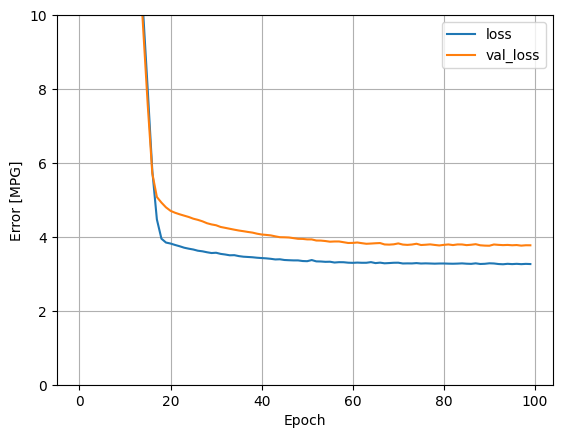

In [127]:
plot_loss(history)

Jeśli wygenerujemy wykres predykcji ajko funkcji zmiennej 'Moc' łatwo zauważyć jak ten model wykorzystuje nieliniowość zapewnianą przez ukryte warstwy:

In [128]:
x = tf.linspace(50.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


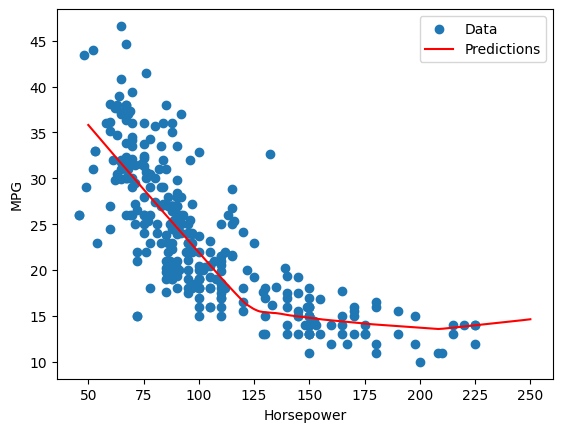

In [129]:
plot_horsepower(x, y)

Zapisujemy rezultat ewaluacji dla tego modelu (na danych testowych)
Na końcu notebok- a przedstwimy porównaie tego wskażnika dla wszystkich modeli

In [130]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Moc'], test_labels,
    verbose=0)

In [131]:
test_results

{'horsepower_model': 3.661005973815918,
 'linear_model': 2.51005220413208,
 'dnn_horsepower_model': 2.9568333625793457}

### Regresja przy wykorzystaniu modelu DNN i wszystkich zmiennych objaśniajacych

Powtórzymy poprzedni proces, używając wszystkich dane wejściowe. Wydajność modelu nieznacznie poprawia się na zestawie danych walidacyjnych.

In [133]:
# podajemy procedurze pełny normalizator (z wysztskimi zmiennymi objasniającymi)
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normaliza  (None, 9)                 19        
 tion)                                                           
                                                                 
 dense_11 (Dense)            (None, 64)                640       
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4884 (19.08 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


In [134]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
8/8 [==============================] - 1s 31ms/step - loss: 22.8651 - val_loss: 22.9275
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 22.1265 - val_loss: 22.1366
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 21.3206 - val_loss: 21.2174
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 20.3619 - val_loss: 20.0802
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 19.1704 - val_loss: 18.6469
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 17.6388 - val_loss: 16.8028
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 15.7113 - val_loss: 14.6400
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 13.5988 - val_loss: 12.5308
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 11.3503 - val_loss: 10.3216
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 8.9505 - val_loss: 7.5952
Epoch 11/1

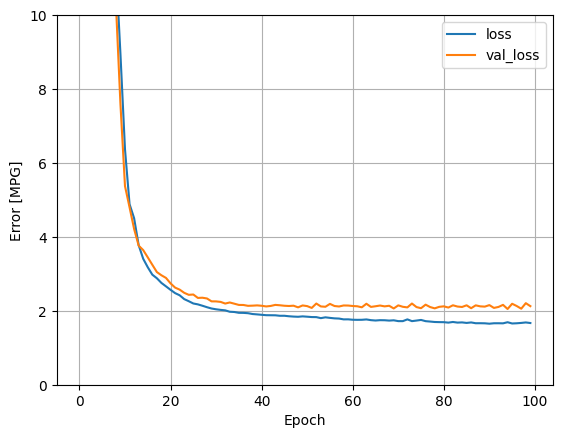

In [135]:
plot_loss(history)

Zapisujemy rezultat ewaluacji tego modelu (dla danych testowych)

In [136]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Porównanie wydajności zbudowanych modeli

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.655619
linear_model,2.458546
dnn_horsepower_model,2.935567
dnn_model,1.672923


### Predykcja

Dokonamy teraz predykcji za pomocą `dnn_model` **na zbiorze testowym** używając Keras `Model.predict`

3/3 [==============================] - 0s 3ms/step


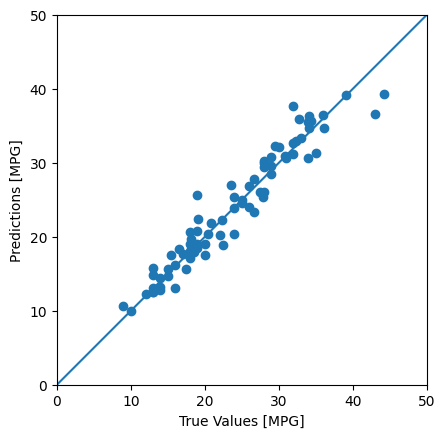

In [137]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Im bliższe skupienie punktów będących wynikami predykcji wokół prostej (rzeczywista wartosc =  przewidywna wartosc) tym lepiej

Wygląda na to, że model przewiduje dość dobrze.

Teraz należy sprawdzić rozkład błędów:

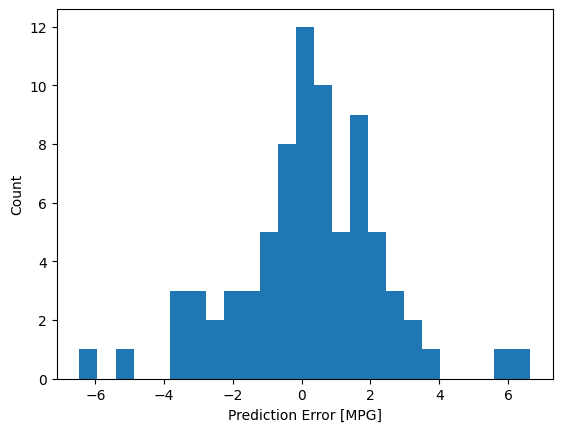

In [138]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')